In [1]:
# -*- coding:utf-8 -*-
# @Python Version: 3.7
# @Time: 2020/5/16 21:10
# @Author: Michael Ming
# @Website: https://michael.blog.csdn.net/
# @File: employee_satisfaction.ipynb
# @Reference:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']=(1,1,1,1) # pycharm 绘图白底，看得清坐标
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import *
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder

In [3]:
# 读取数据
tr_data = pd.read_csv("train.csv",index_col='id')
X_test = pd.read_csv("test.csv",index_col='id') # 不含标签

tr_data.head(10)

,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,package,promotion_last_5years,division,salary,satisfaction_level
id,,,,,,,,,,
13697,0.99,3,161.39,2,0,a,0,accounting,medium,0.681
1142,1.00,5,226.22,6,0,b,0,marketing,low,0.876
7954,0.91,5,199.45,2,0,e,0,sales,medium,0.955
2225,0.51,3,235.14,3,0,c,0,sales,low,0.817
9753,0.89,3,219.91,2,0,a,0,technical,low,0.920
8661,0.75,4,258.68,3,1,a,0,technical,low,0.490
10963,0.59,4,149.19,3,0,c,0,support,low,0.597
2761,0.85,3,146.21,3,0,a,0,sales,medium,0.629
14839,0.85,5,244.16,6,0,d,0,sales,low,0.713


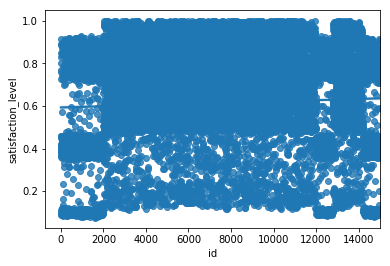

In [4]:
tr_data.corr()
sns.regplot(x=tr_data.index, y=tr_data['satisfaction_level'])

In [5]:
X = tr_data.drop(['satisfaction_level'], axis=1)
y = tr_data['satisfaction_level']
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2,random_state=1)
X_train
feature = X_train.columns
print(feature)
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)
y_train
# 查看标签值，是一系列的浮点数
pd.unique(y_train)



Index(['last_evaluation', 'number_project', 'average_monthly_hours',
       'time_spend_company', 'Work_accident', 'package',
       'promotion_last_5years', 'division', 'salary'],
      dtype='object')
['package', 'division', 'salary']


array([0.774, 0.419, 0.955, 0.864, 0.395, 0.788, 0.888, 0.57 , 0.775,
       0.967, 0.106, 0.096, 0.215, 0.601, 0.912, 0.25 , 0.373, 0.852,
       0.957, 0.878, 0.662, 0.362, 0.522, 0.865, 0.434, 0.315, 0.84 ,
       0.621, 0.353, 0.611, 0.435, 0.756, 0.367, 0.717, 0.646, 0.777,
       0.115, 0.668, 0.453, 0.37 , 0.083, 0.824, 0.11 , 0.797, 0.78 ,
       0.119, 0.38 , 0.616, 0.629, 0.234, 0.465, 0.677, 0.55 , 0.374,
       0.826, 0.936, 0.697, 0.85 , 0.976, 0.421, 0.09 , 0.099, 0.952,
       0.531, 0.849, 0.431, 0.226, 0.901, 0.603, 0.605, 0.786, 0.839,
       0.416, 0.813, 0.82 , 0.459, 0.44 , 0.236, 0.499, 0.763, 0.661,
       0.75 , 0.733, 0.637, 0.73 , 0.844, 0.178, 0.517, 0.571, 0.449,
       0.933, 0.898, 0.685, 0.58 , 0.138, 0.897, 0.969, 0.368, 0.889,
       0.456, 0.168, 0.954, 0.764, 0.575, 0.893, 0.673, 0.672, 0.739,
       0.653, 0.842, 0.394, 0.903, 0.867, 0.652, 0.087, 0.701, 0.109,
       0.838, 0.594, 0.989, 0.705, 0.485, 0.682, 0.123, 0.961, 0.102,
       0.479, 0.097,

In [6]:
# 数字特征
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)


In [7]:
# 检查是否有列中，数据集之间的值的种类有差异，防止编码transform出错，经检查没有bad
good_label_cols = [col for col in object_cols if
                   set(X_train[col]) == set(X_valid[col])]
good_label_cols
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
bad_label_cols

good_label_cols = [col for col in object_cols if
                   set(X_train[col]) == set(X_test[col])]
good_label_cols
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
bad_label_cols

[]

In [8]:
# 文字特征
cat_X_train = X_train[good_label_cols]
cat_X_valid = X_valid[good_label_cols]
cat_X_test = X_test[good_label_cols]
cat_X_train

,package,division,salary
id,,,
10824,a,IT,medium
1325,d,accounting,medium
12866,a,support,low
13239,a,sales,low
1423,d,support,low
...,...,...,...
796,d,hr,low
3456,c,sales,medium
2075,c,sales,low


In [9]:
# 文字特征转换成数字特征
labEncoder = LabelEncoder()
for f in set(good_label_cols):
    cat_X_train[f] = labEncoder.fit_transform(cat_X_train[f])
    cat_X_valid[f] = labEncoder.transform(cat_X_valid[f])
    cat_X_test[f] = labEncoder.transform(cat_X_test[f])
cat_X_train

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,package,division,salary
id,,,
10824,0,0,2
1325,3,2,2
12866,0,8,1
13239,0,7,1
1423,3,8,1
...,...,...,...
796,3,3,1
3456,2,7,2
2075,2,7,1


In [10]:
cat_X_train.index = X_train.index
X_train_final = pd.concat([num_X_train, cat_X_train], axis=1)
X_train_final
# for i in feature:
#     sns.regplot(x=X_train_final[i],y=y_train)
#     plt.show()

cat_X_valid.index = X_valid.index
X_valid_final = pd.concat([num_X_valid, cat_X_valid], axis=1)

cat_X_test.index = X_test.index
cat_X_test
X_test_final = pd.concat([num_X_test, cat_X_test], axis=1)
X_test_final

,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,package,division,salary
id,,,,,,,,,
4615,0.78,4,260.71,2,0,0,4,9,2
1680,0.96,7,275.38,5,0,0,1,5,1
8866,0.57,4,207.29,5,0,0,4,7,1
7525,0.89,5,150.70,4,0,0,2,9,2
5389,0.93,3,141.23,2,0,0,4,8,2
...,...,...,...,...,...,...,...,...,...
8434,0.45,3,132.90,2,0,0,2,9,1
14013,0.73,4,245.77,2,0,0,0,7,1
10221,0.75,4,242.90,4,0,0,0,6,1


In [11]:
model1 = lr()
model1.fit(X_train_final, y_train)
# cross_val_score(model1,X_train_final,y_train,cv=10,scoring='neg_mean_squared_error')
y_pred_valid = model1.predict(X_valid_final)
mean_absolute_error(y_pred_valid, y_valid)


NameError: name 'AdaBoostRegressor' is not defined

In [ ]:
y_pred_test = model1.predict(X_test_final)
result = pd.DataFrame()
result['id'] = X_test.index
result['satisfaction_level'] = y_pred_test
result.to_csv('lr_no_num_scale.csv',index=False)